# Introduction to Machine Learning

https://dmol.pub/ml/introduction.html

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
from jax.example_libraries import optimizers
import sklearn.manifold, sklearn.cluster
import rdkit, rdkit.Chem, rdkit.Chem.Draw
# import dmol

## 1. Supervised learning

### 1.1. Data

The data used is a set of molecules with 17 parameters and their solubility

In [20]:
# soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
# had to rehost because dataverse isn't reliable
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


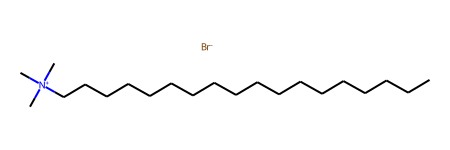

In [21]:
# plot one molecule
mol = rdkit.Chem.MolFromInchi(soldata.InChI[0])
mol

/home/eloi/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


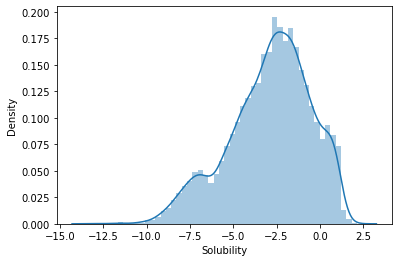

In [22]:
sns.distplot(soldata.Solubility)
plt.show()

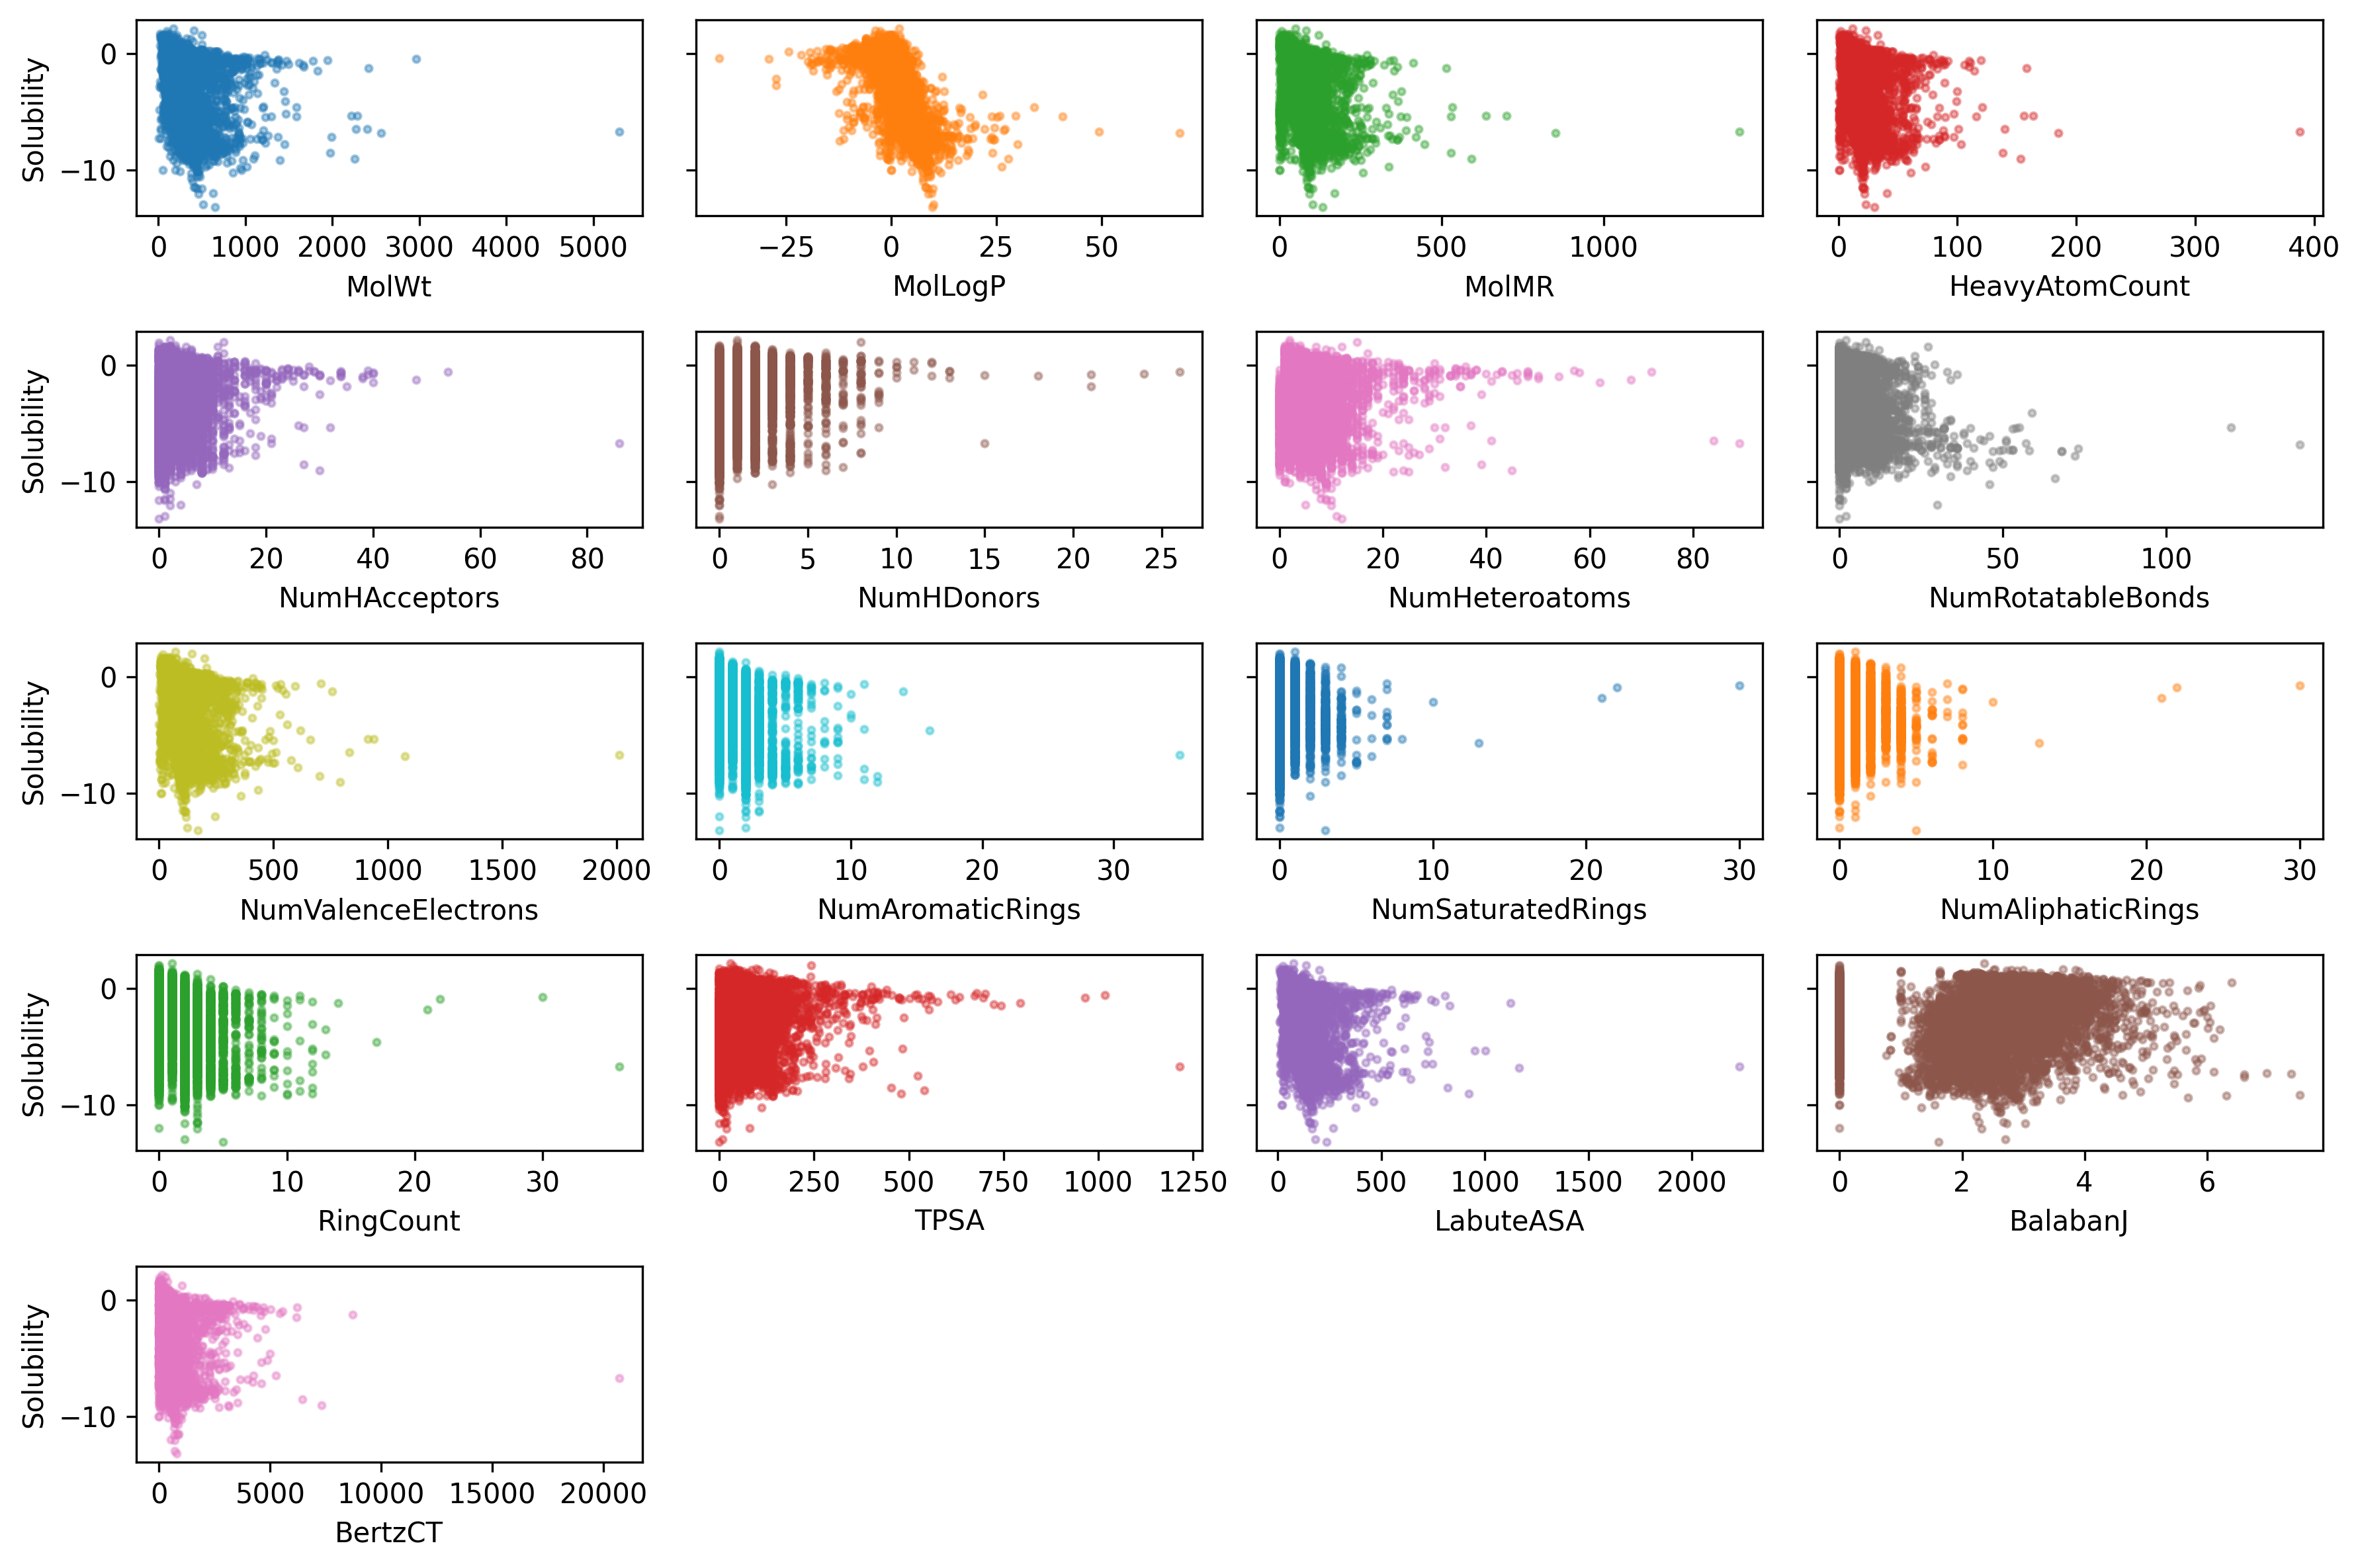

In [23]:
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]

fig, axs = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(12, 8), dpi=300)
axs = axs.flatten()  # so we don't have to slice by row and column
for i, n in enumerate(feature_names):
    ax = axs[i]
    ax.scatter(
        soldata[n], soldata.Solubility, s=6, alpha=0.4, color=f"C{i}"
    )  # add some color
    if i % 4 == 0:
        ax.set_ylabel("Solubility")
    ax.set_xlabel(n)
# hide empty subplots
for i in range(len(feature_names), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()

### 1.3. Linear Model

We will try create a linear model: 
$$y=\vec{w}·\vec{x}+b$$

The shape of the $\vec{x}$ is 17. Same for the $\vec{w}$ and $b$, but they are adjustable parameters.

In [24]:
def linear_model(x, w, b):
    return jnp.dot(x, w) + b


# test it out
x = np.array([1, 0, 2.5])
w = np.array([0.2, -0.5, 0.4])
b = 4.3

linear_model(x, w, b)

DeviceArray(5.5, dtype=float32)

### 1.4. Gradient Descent

How do we find the adjustable parameters? The *correct* method for linear models would be to use the [pseudo-inverse](https://nbviewer.org/github/whitead/numerical_stats/blob/master/unit_12/lectures/lecture_1.ipynb#Extending-Least-Squares-to-Multiple-Dimensions-in-Domain---OLS-ND). However, we will use a gradient-descent method because is the usual in Deep Learning.

We define a function (loss function) that must be minimized. Then we find the parameters that minimize such function.

In [25]:
# convert data into features, labels
features = soldata.loc[:, feature_names].values  # The X matrix (data)
labels = soldata.Solubility.values               # The y vector (solubility)

feature_dim = features.shape[1]

# initialize our paramaters randomly
w = np.random.normal(size=feature_dim)
b = 0.0

# define loss
def loss(y, labels):
    return jnp.mean((y - labels) ** 2)


# test it out
y = linear_model(features, w, b)
loss(y, labels)

DeviceArray(541270.2, dtype=float32)

Now we want to minimize the loss function with repect to the variable parameters. To do this we find the gradient of the loss function and modify the parameters to the direction with the highest negative gradient.

The loss function is
$$L=\frac{1}{N}\sum_i^N[y_i-f(\vec{x},\vec{w},b)]^2$$
and the gradient is 
$$\frac{\partial L}{\partial w_i}, \frac{\partial L}{\partial b} $$
Therefore, the new parameters are found with
$$(w_i,b)'=(w_i-\eta \frac{\partial L}{\partial w_i}, b - \frac{\partial L}{\partial b} )$$

Where $\eta$ is the learning rate and is an *hyperparameter* which we just guess to be $1\times10^{-6}$.

In [26]:
# compute gradients
def loss_wrapper(w, b, data):
    features = data[0]
    labels = data[1]
    y = linear_model(features, w, b)
    return loss(y, labels)


loss_grad = jax.grad(loss_wrapper, (0, 1))  # We calculate the gradient using the arguments first (0) and second (1)

# test it out
loss_grad(w, b, (features, labels))

(DeviceArray([4.3866772e+05, 2.7912261e+03, 1.0933573e+05, 2.9163775e+04,
              6.2111455e+03, 1.5419830e+03, 8.8950283e+03, 6.2323887e+03,
              1.5305372e+05, 2.2303391e+03, 3.8079086e+02, 7.0240521e+02,
              2.9327476e+03, 1.0472590e+05, 1.8194108e+05, 1.9313104e+03,
              1.0567622e+06], dtype=float32),
 DeviceArray(978.4187, dtype=float32, weak_type=True))

Now we can modify the values of the parameters to minimize the gradient over a few steps. The figure plotted is called *training curve*.

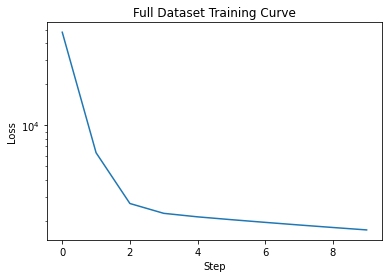

In [27]:
loss_progress = []
eta = 1e-6
data = (features, labels)

# We use the full dataset to calculate the gradient
for i in range(10):
    grad = loss_grad(w, b, data)
    w -= eta * grad[0]
    b -= eta * grad[1]
    loss_progress.append(loss_wrapper(w, b, data))
plt.plot(loss_progress)

plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Full Dataset Training Curve")
plt.show()

### 1.5. Batching

We’ll use *batching*, which is how training is actually done in machine learning. The small change is that rather than using all data at once, we only take a small *batch* of data. Batching provides two benefits: it reduces the amount of time to compute an update to our parameters, and it makes the training process random. The randomness makes it possible to escape local minima that might stop training progress. This addition of batching makes our algorithm stochastic and thus we call this procedure *stochastic gradient descent* (SGD). SGD, and variations of it, are the most common methods of training in deep learning.

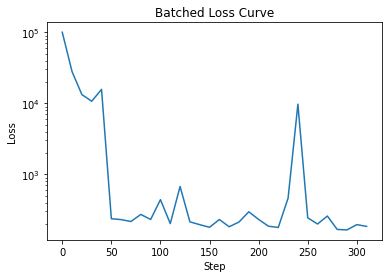

In [28]:
# initialize our paramaters
# to be fair to previous method
w = np.random.normal(size=feature_dim)
b = 0.0

loss_progress = []
eta = 1e-6
batch_size = 32
N = len(labels)  # number of data points. Remember labels is the y vector
data = (features, labels)
# compute how much data fits nicely into a batch
# and drop extra data
new_N = N // batch_size * batch_size

# the -1 means that numpy will compute
# what that dimension should be
batched_features = features[:new_N].reshape((-1, batch_size, feature_dim))
batched_labels = labels[:new_N].reshape((-1, batch_size))
# to make it random, we'll iterate over the batches randomly
indices = np.arange(new_N // batch_size)
np.random.shuffle(indices)
for i in indices:
    # choose a random set of
    # indices to slice our data
    grad = loss_grad(w, b, (batched_features[i], batched_labels[i]))
    w -= eta * grad[0]
    b -= eta * grad[1]
    # we still compute loss on whole dataset, but not every step
    if i % 10 == 0:
        loss_progress.append(loss_wrapper(w, b, data))

plt.plot(np.arange(len(loss_progress)) * 10, loss_progress)
plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Batched Loss Curve")
plt.show()

There are three changes to note:
1. The loss is lower than without batching
2. There are more steps, even though we iterated over our dataset once instead of 10 times
3. The loss doesn’t always go down

The reason the loss doesn’t always go down is that each time we evaluate it, it’s on a different set of data. Some molecules are harder to predict than others. Also, each step we take in minimizing loss may not be correct because we only updated our parameters based on one batch. Assuming our batches are mixed though, we will always improve in expectation (on average).

It seems we cannot get past a certain loss. If you examine the gradients you’ll see some of them are very large and some are very small. Each of the features have different magnitudes.

In [29]:
loss_grad(w, b, (batched_features[0], batched_labels[0]))

(DeviceArray([-4.4441875e+03, -7.4484207e+01, -1.1346235e+03,
              -2.4695378e+02, -4.7158611e+01, -8.3817232e-01,
              -6.5422638e+01, -1.3216075e+02, -1.4363696e+03,
              -8.3837576e+00,  6.0541925e+00,  7.5345631e+00,
              -8.4919524e-01, -1.7523775e+02, -1.6926189e+03,
               6.4097887e-01, -4.8393584e+03], dtype=float32),
 DeviceArray(-5.3987923, dtype=float32, weak_type=True))

### 1.6. Standardization of data

Each of these must use the same learning rate, $\eta$, and that is ok for some but too small for others. If we increase $\eta$, our training procedure will explode because of these larger feature gradients. A standard trick we can do is make all the features have the same magnitude by standardization.
$$ x_{ij}=\frac{x_{ij}-\bar{x}_j}{\sigma_{x_j}}$$
where $\bar{x}_j$ is the column mean and $\sigma_{x_j}$ its standard deviation.

Note that we cannot use the testing set for the standarization (or the calculation of the mean or the std) since we require that our model has NO information at all besides the training set.

In [30]:
fstd = np.std(features, axis=0)
fmean = np.mean(features, axis=0)
std_features = (features - fmean) / fstd  # The standarized features (X matrix, the data)

Repeat the training, now with the standarized data and using the dataset 3 times (3 epochs)

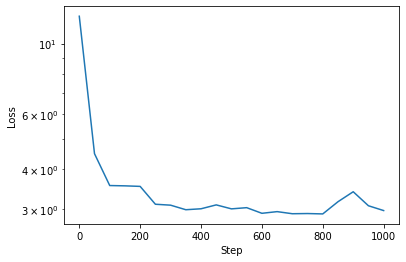

In [34]:
# initialize our paramaters
# since we're changing the features
w = np.random.normal(scale=0.1, size=feature_dim)
b = 0.0


loss_progress = []
eta = 1e-2
batch_size = 32
N = len(labels)  # number of data points
data = (std_features, labels)
# compute how much data fits nicely into a batch
# and drop extra data
new_N = len(labels) // batch_size * batch_size
num_epochs = 3

# the -1 means that numpy will compute
# what that dimension should be
batched_features = std_features[:new_N].reshape((-1, batch_size, feature_dim))
batched_labels = labels[:new_N].reshape((-1, batch_size))
indices = np.arange(new_N // batch_size)

# iterate through the dataset 3 times
for epoch in range(num_epochs):
    # to make it random, we'll iterate over the batches randomly
    np.random.shuffle(indices)
    for i in indices:
        # choose a random set of
        # indices to slice our data
        grad = loss_grad(w, b, (batched_features[i], batched_labels[i]))
        w -= eta * grad[0]
        b -= eta * grad[1]
        # we still compute loss on whole dataset, but not every step
        if i % 50 == 0:
            loss_progress.append(loss_wrapper(w, b, data))

plt.plot(np.arange(len(loss_progress)) * 50, loss_progress)
plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.show()

### 1.7. Model performance

We can use a *Parity plot* which plots the predicted solubility against the measured one. A perfect fit would fall on the line $y=\hat{y}$.

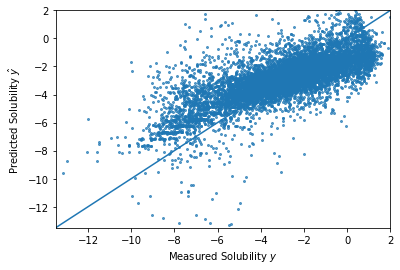

In [35]:
predicted_labels = linear_model(std_features, w, b)

plt.plot([-100, 100], [-100, 100])
plt.scatter(labels, predicted_labels, s=4, alpha=0.7)
plt.xlabel("Measured Solubility $y$")
plt.ylabel("Predicted Solubility $\hat{y}$")
plt.xlim(-13.5, 2)
plt.ylim(-13.5, 2)
plt.show()

We can also chech the *correlation coefficient* for the lineal model.

In [36]:
# slice correlation between predict/labels
# from correlation matrix
np.corrcoef(labels, predicted_labels)[0, 1]

0.6909654227492759

## 2. Unsupervised learning

In unsupervised learning, the goal is to predict $\hat{y}$ without labels. This seems like an impossible task. How do we judge success? Typically, unsupervised learning can be broken into three categories:

**Clustering**

Here we assume $\{y_i\}$ is a class variable and try to partition our features into these classes. In clustering we are simultaneously learning the definition of the classes (called clusters) and which cluster each feature should be assigned to

**Finding Signal**

$x$ is assumed to be of two components: noise and signal ($y$). We try to separate each other and discard noise. Related to *Representation learning*.

**Generative**

Generative methods are methods where we try to learn $P(x)$ so that we can sample new values of $x$. It is analogous to $y$ being probability and we’re trying to estimate it.

### 2.1. Clustering

Clustering is historically one of the most well-known and still popular machine learning methods. It’s always popular because it can provide new insight from data. Clustering gives class labels where none existed and thus can help find patterns in data.

We’ll look at the classic clustering method: [k-means](https://en.wikipedia.org/wiki/K-means_clustering). To make our clustering actually visible, we’ll start by projecting our features into 2 dimensions. This will be covered in representation learning, so don’t worry about these steps.

In [37]:
# get down to 2 dimensions for easy visuals
embedding = sklearn.manifold.Isomap(n_components=2)
# only fit to every 25th point to make it fast
embedding.fit(std_features[::25, :])
reduced_features = embedding.transform(std_features)

We’re going to zoom into the middle 99th percentile of the data since some of the points are extremely far away

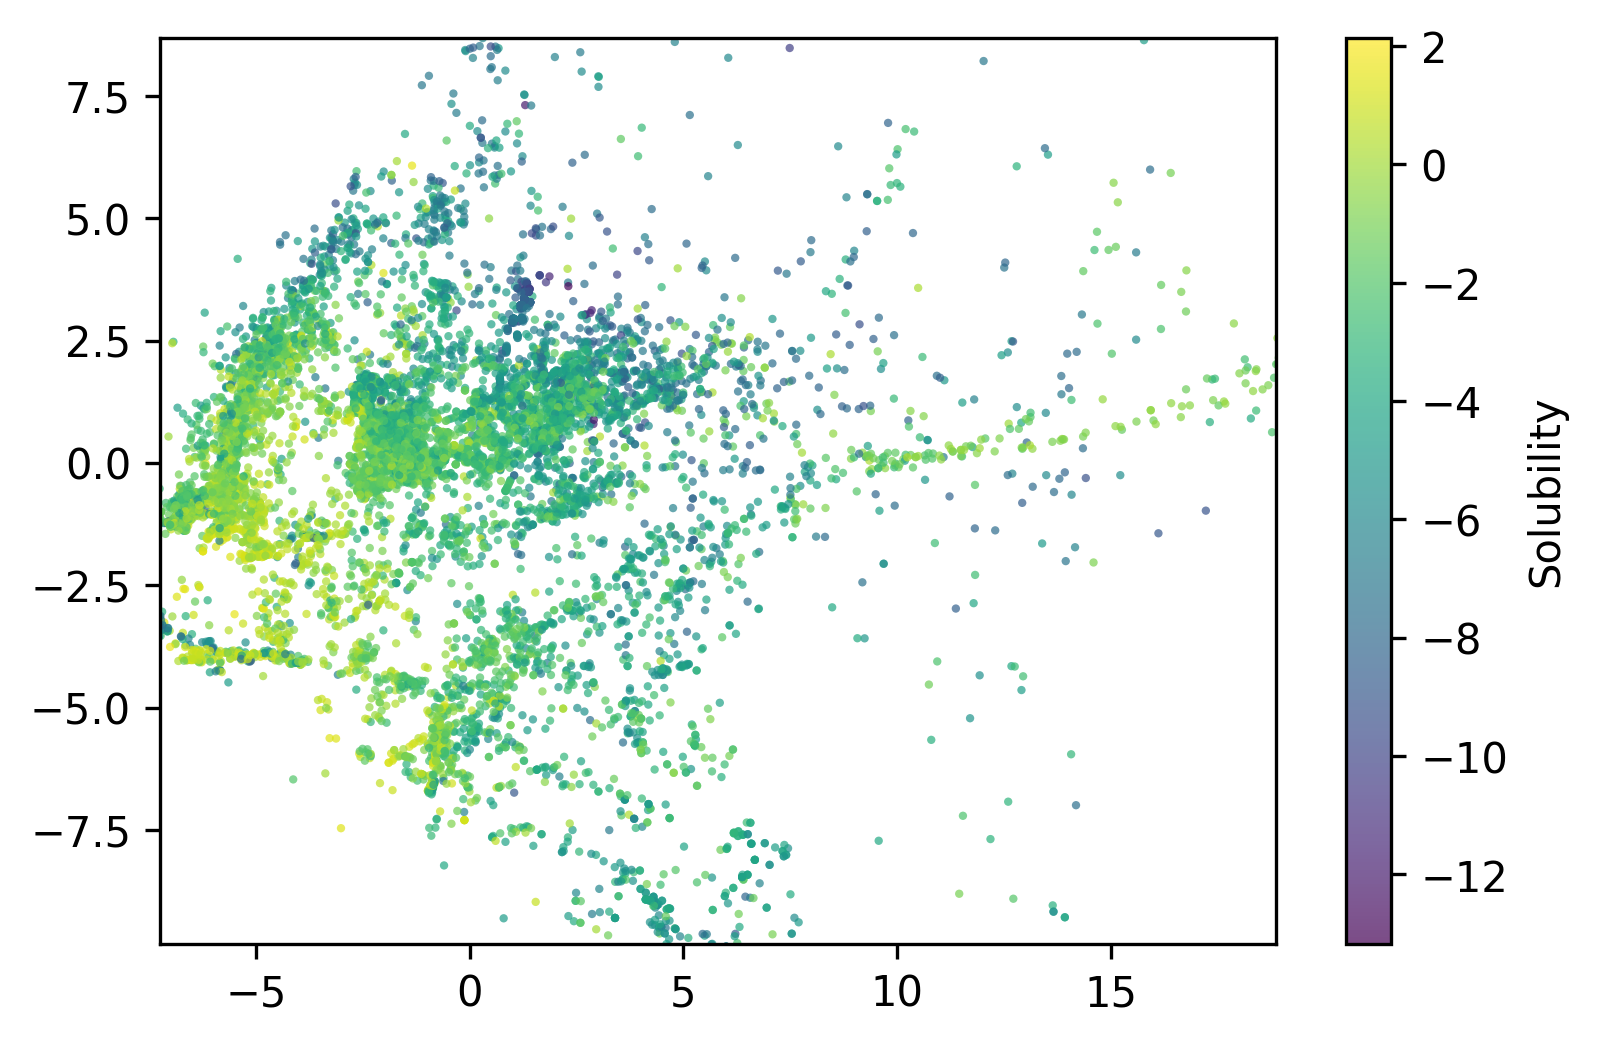

In [38]:
xlow, xhi = np.quantile(reduced_features, [0.005, 0.995], axis=0)

plt.figure(dpi=300)
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    s=4,
    alpha=0.7,
    c=labels,
    edgecolors="none",
)
plt.xlim(xlow[0], xhi[0])
plt.ylim(xlow[1], xhi[1])
cb = plt.colorbar()
cb.set_label("Solubility")
plt.show()

The dimensionality reduction has made our features only 2 dimensions. We can see some structure, especially with the solubility as the coloring. Note in these kind of plots, where we have reduced dimensions in someway, we do not label the axes because they are arbitrary.

Now we cluster. The main challenge in clustering is deciding how many clusters there should be. There are a number of methods out there, but they basically come down to intuition. You, as the chemist, should use some knowledge outside of the data to intuit what is the cluster number. Sounds unscientific? Yeah, that’s why clustering is hard.

In [39]:
# cluster - using whole features
kmeans = sklearn.cluster.KMeans(n_clusters=4, random_state=0)
kmeans.fit(std_features)

KMeans(n_clusters=4, random_state=0)

Now we’ll visualize by coloring our data by the class assigned.

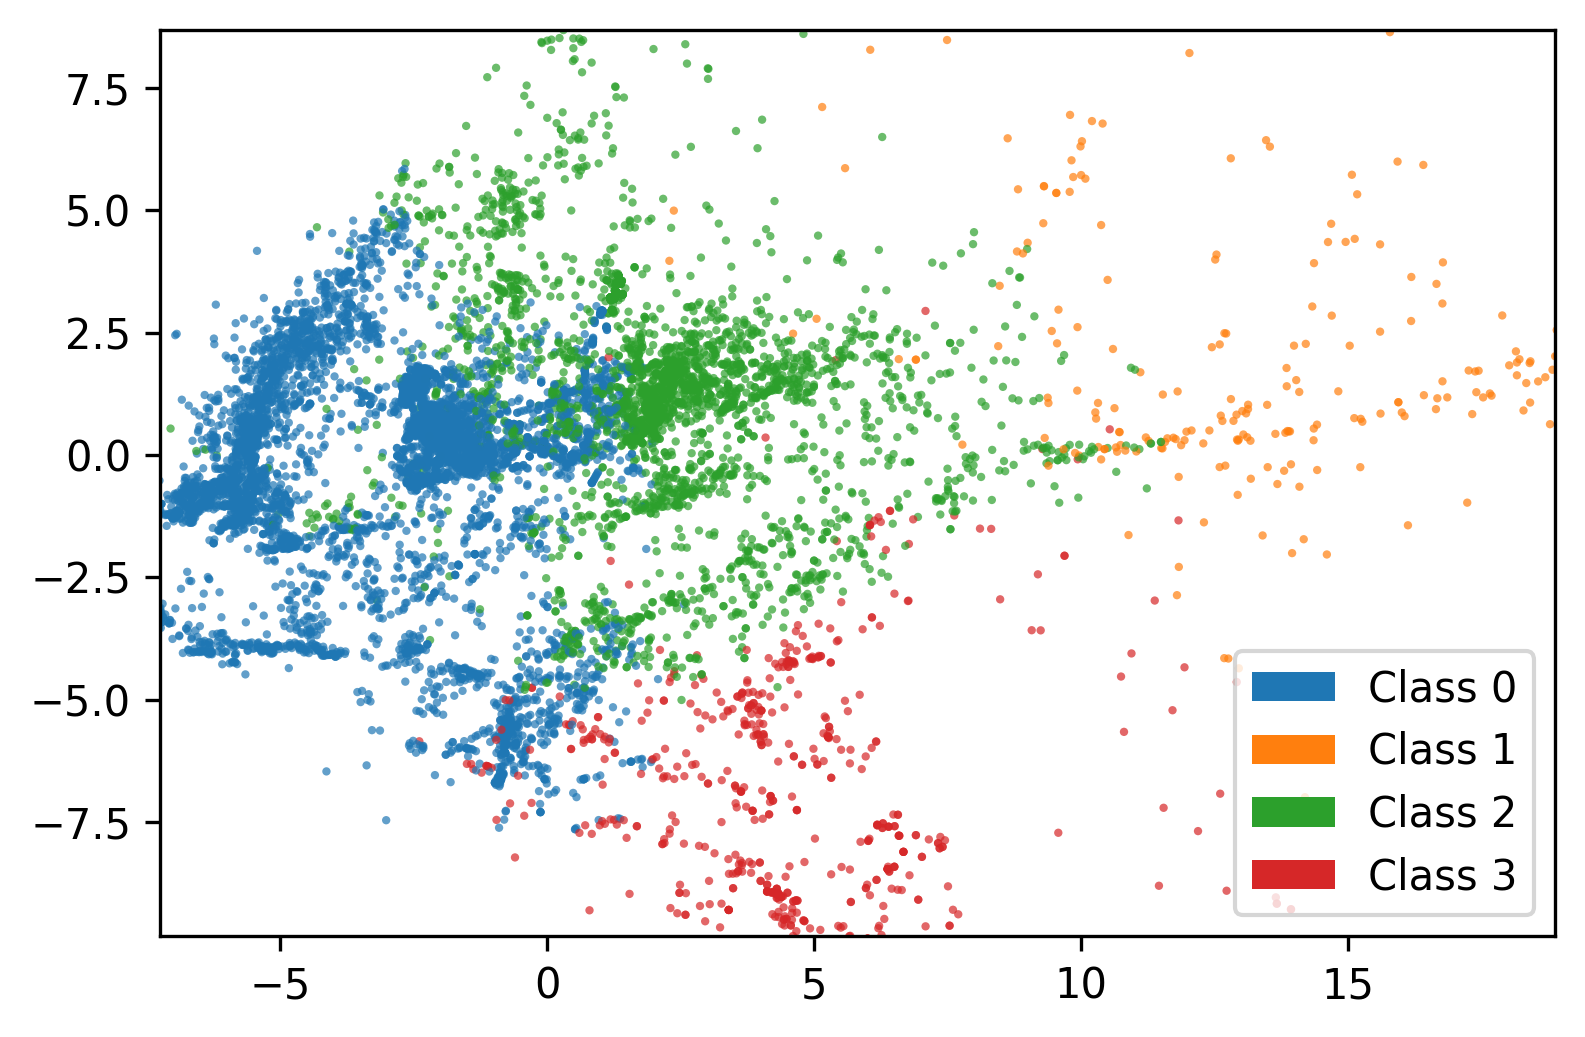

In [40]:
plt.figure(dpi=300)
point_colors = [f"C{i}" for i in kmeans.labels_]
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    s=4,
    alpha=0.7,
    c=point_colors,
    edgecolors="none",
)
# make legend
legend_elements = [
    plt.matplotlib.patches.Patch(
        facecolor=f"C{i}", edgecolor="none", label=f"Class {i}"
    )
    for i in range(4)
]
plt.legend(handles=legend_elements)
plt.xlim(xlow[0], xhi[0])
plt.ylim(xlow[1], xhi[1])
plt.show()

## 2.2. Choosing cluster number

How do we know we had the correct number? Intuition. There is one tool we can use to help us, called an elbow plot. The k-means clusters can be used to compute the mean squared distance from cluster center, basically a version of loss function. However, if we treat cluster number as a trainable parameter we’d find the best fit at the cluster number being equal to number of data points. Not helpful! However, we can see when the slope of this loss becomes approximately constant and assume that those extra clusters are adding no new insight. Let’s plot the loss and see what happens. Note we’ll be using a subsample of the dataset to save time.

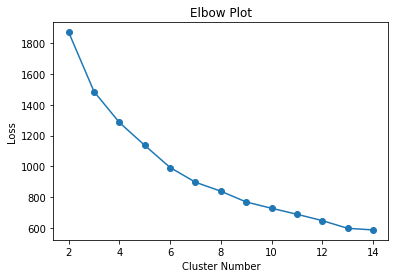

In [41]:
# make an elbow plot
loss = []
cn = range(2, 15)
for i in cn:
    kmeans = sklearn.cluster.KMeans(n_clusters=i, random_state=0)
    # use every 50th point
    kmeans.fit(std_features[::50])
    # we get score -> opposite of loss
    # so take -
    loss.append(-kmeans.score(std_features[::50]))

plt.plot(cn, loss, "o-")
plt.xlabel("Cluster Number")
plt.ylabel("Loss")
plt.title("Elbow Plot")
plt.show()

Where is the transition? If I squint, maybe at 6? 3? 4? 7? Let’s choose 4 because it sounds nice and is plausible based on the data. The last task is to get some insight into what the clusters actually are. We can extract the most centered data points (closest to cluster center) and consider them to be representative of the cluster.

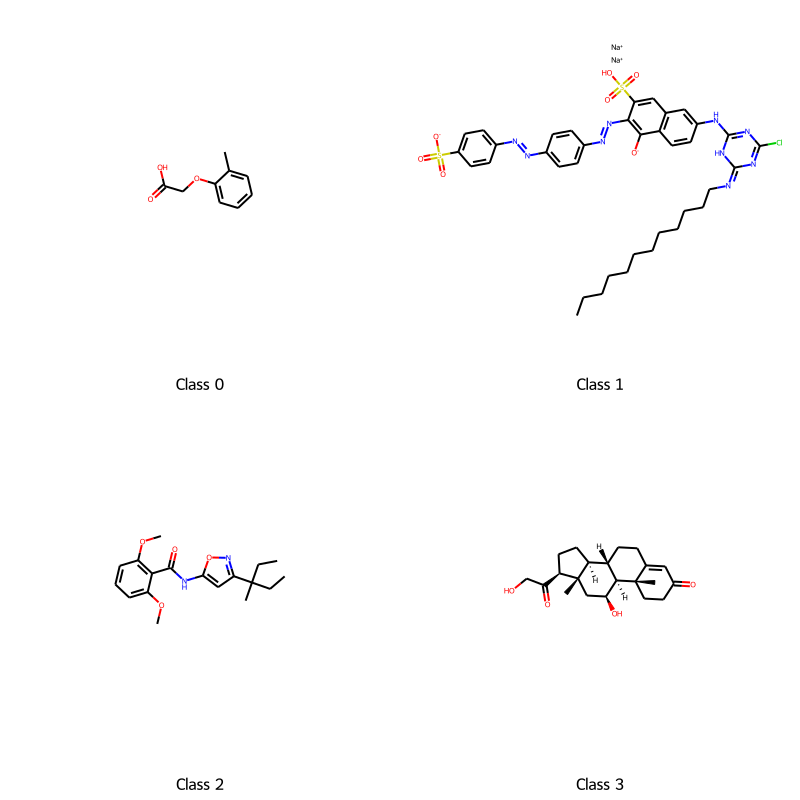

In [42]:
# cluster - using whole features
kmeans = sklearn.cluster.KMeans(n_clusters=4, random_state=0)
kmeans.fit(std_features)

cluster_center_idx = []
for c in kmeans.cluster_centers_:
    # find point closest
    i = np.argmin(np.sum((std_features - c) ** 2, axis=1))
    cluster_center_idx.append(i)
cluster_centers = soldata.iloc[cluster_center_idx, :]

legend_text = [f"Class {i}" for i in range(4)]

# now plot them on a grid
cluster_mols = [rdkit.Chem.MolFromInchi(inchi) for inchi in cluster_centers.InChI]
rdkit.Chem.Draw.MolsToGridImage(
    cluster_mols, molsPerRow=2, subImgSize=(400, 400), legends=legend_text
)

So what exactly are these classes? Unclear. We intentionally did not reveal solubility (unsupervised learning) so there is not necessarily any connection with solubility. These classes are more a result of which features were chosen for the dataset. You could make a hypothesis, like class 1 is all negatively charged or class 0 is aliphatic, and investigate. Ultimately though there is no best clustering and often unsupervised learning is more about finding insight or patterns and not about producing a highly-accurate model.